In [1]:
%load_ext zipline

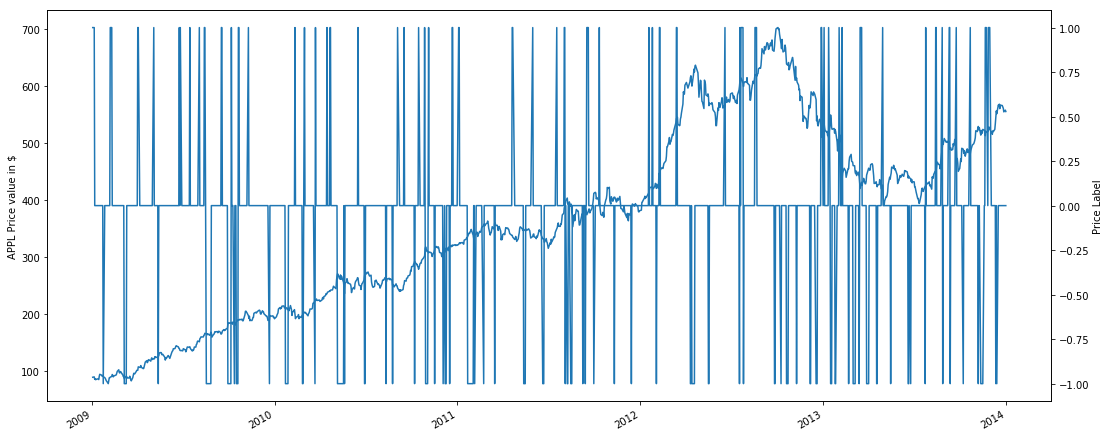

,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,ending_value,...,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return,x,y
2009-01-02 21:00:00+00:00,NaN,0.0,NaN,-0.004789,NaN,NaN,0.0,10000000.0,0.0,0.0,...,0,None,10000000.0,0.0,0.0,1,[],0.0,89.430,1
2009-01-05 21:00:00+00:00,0.0,0.0,NaN,-0.009555,0.000000,NaN,0.0,10000000.0,0.0,0.0,...,0,None,10000000.0,0.0,0.0,2,[],0.0,90.000,1
2009-01-06 21:00:00+00:00,0.0,0.0,NaN,-0.014298,0.000000,NaN,0.0,10000000.0,0.0,0.0,...,0,None,10000000.0,0.0,0.0,3,[],0.0,85.740,0
2009-01-07 21:00:00+00:00,0.0,0.0,NaN,-0.019018,0.000000,NaN,0.0,10000000.0,0.0,0.0,...,0,None,10000000.0,0.0,0.0,4,[],0.0,86.380,0
2009-01-08 21:00:00+00:00,0.0,0.0,NaN,-0.023716,0.000000,NaN,0.0,10000000.0,0.0,0.0,...,0,None,10000000.0,0.0,0.0,5,[],0.0,85.040,0
2009-01-09 21:00:00+00:00,0.0,0.0,NaN,-0.028391,0.000000,NaN,0.0,10000000.0,0.0,0.0,...,0,None,10000000.0,0.0,0.0,6,[],0.0,85.810,0
2009-01-12 21:00:00+00:00,0.0,0.0,NaN,-0.033044,0.000000,NaN,0.0,10000000.0,0.0,0.0,...,0,None,10000000.0,0.0,0.0,7,[],0.0,86.610,0
2009-01-13 21:00:00+00:00,0.0,0.0,NaN,-0.037675,0.000000,NaN,0.0,10000000.0,0.0,0.0,...,0,None,10000000.0,0.0,0.0,8,[],0.0,86.290,0
2009-01-14 21:00:00+00:00,0.0,0.0,NaN,-0.042283,0.000000,NaN,0.0,10000000.0,0.0,0.0,...,0,None,10000000.0,0.0,0.0,9,[],0.0,85.350,0
2009-01-15 21:00:00+00:00,0.0,0.0,NaN,-0.046870,0.000000,NaN,0.0,10000000.0,0.0,0.0,...,0,None,10000000.0,0.0,0.0,10,[],0.0,90.750,0


In [13]:
%%zipline --start 2009-1-1 --end 2014-1-1  -o ../data/generate_data.pickle

import matplotlib.pyplot as plt
import talib
import pickle
from talib import BBANDS
from zipline.api import (
    sid, 
    symbol,
    schedule_function, 
    date_rules, 
    time_rules,
    order_target_percent,
    record)


def getLabel(prices, days, proft_taking, loss_stopping):
    profit_take_timing = None
    loss_stop_timing = None
    for i, price in enumerate(prices):
        if price > proft_taking and not profit_take_timing:
            profit_take_timing = i
        
        if price < loss_stopping and not loss_stop_timing:
            loss_stop_timing = i
        
    if profit_take_timing and loss_stop_timing:
        return profit_take_timing < loss_stop_timing
    if profit_take_timing:
        return 1
    if loss_stop_timing:
        return -1
    return 0
            
            
def initialize(context):
    context.asset = symbol('AAPL')
    schedule_function(
        tracker, 
        date_rules.every_day(), 
        time_rules.market_open())     
    
# Rebalance daily.
def tracker1(context, data):
    current_position = context.portfolio.positions[context.asset].amount
    days = 10
    # Load historical data for the stocks
    prices = data.history(context.asset, 
                          fields='price', 
                          bar_count=days, 
                          frequency='1d')
    
    future_price = prices[1:].means()  
    upper, middle, lower = talib.BBANDS(
        prices, 
        timeperiod=days-1,
        # number of non-biased standard deviations from the mean
        nbdevup=2,
        nbdevdn=2,
        # Moving average type: simple moving average here
        matype=0)
    
    proft_taking = prices[0] + 0.1 #upper[-1] 
    loss_stopping = prices[0] - 0.1 # lower[-1]
    y = getLabel(prices[1:], days, proft_taking, loss_stopping)
    record(x=prices[0],
          y = y)
    
    
def tracker(context, data):
    current_position = context.portfolio.positions[context.asset].amount
    days = 10
    # Load historical data for the stocks
    prices = data.history(context.asset, 
                          fields='price', 
                          bar_count=days, 
                          frequency='1d')
    
    upper, middle, lower = talib.BBANDS(
        prices, 
        timeperiod=days-1,
        # number of non-biased standard deviations from the mean
        nbdevup=2,
        nbdevdn=2,
        # Moving average type: simple moving average here
        matype=0)
    
    proft_taking = upper[-1] 
    loss_stopping = lower[-1]
    y = getLabel(prices[1:], days, proft_taking, loss_stopping)
    record(x=prices[0],
          y = y)
    
    
def analyze(context, perf):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    perf['x'].plot(ax=ax1)
    
    ax12 = ax1.twinx()
    perf['y'].plot(ax=ax12)
    
    ax1.set_ylabel('APPL Price value in $')
        
    ax12.set_ylabel('Price Label')
    plt.gcf().set_size_inches(18, 8)
    plt.show()
    perf.to_pickle("../data/data.pickle")